# **Import Library**

In [1]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from statsmodels.tsa.stattools import kpss
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import statsmodels
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')


In [2]:
def adjust(val, length= 6): 
    return str(val).ljust(length)

In [3]:
# Define function adf_test
def adf_test(x):
    '''
    Null Hypothesis: time series is not stationary
    Alternate Hypothesis: time series is stationary
    '''
    indices = ['Test Statistic', 'p-value',
               '# of Lags Used', '# of Observations Used']

    adf_test = adfuller(x, autolag='AIC')
    results = pd.Series(adf_test[0:4], index = indices)

    for key, value in adf_test[4].items():
        results[f'Critical Value ({key})'] = value

    return results

# Define kpss test
def kpss_test(x):
    '''
    Null Hypothesis: time series is stationary
    Alternate Hypothesis: time series is not stationary
    '''
    indices = ['Test Statistic', 'p-value', '# of Lags']

    kpss_test = kpss(x)
    results = pd.Series(kpss_test[0:3], index = indices)

    for key, value in kpss_test[3].items():
        results[f'Critical Value ({key})'] = value

    return results

# **VECTOR AUTO REGRESSION EQUATION:**


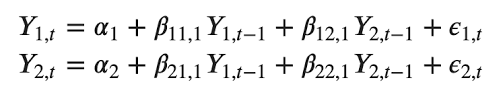

**Two important assumptions here are:**

*1. Both x1, x2, ..., xn are stationary*

*2. There exists a linear relation between their current and past values.*

In [4]:
# Read data
df = pd.read_csv(r'C:\Users\ASUS\Desktop\Study\Year_3\HK_6\Machine Learning\Multivariable GARCH\Bond-VN.csv',index_col=0,parse_dates = True)
df.drop(['GGVF3Y','FIR','Baserate','Pubdebt'],axis=1,inplace=True)

In [5]:
df.head()

,GGVF1Y,GGVF5Y,CPI,FER,Oilrate,Stockreturn,Fiscal,CurrentAcc
Time,,,,,,,,
2006-07-01,0.06150,0.08670,0.368,13384067982,0.581238,-18.072499,1.22461,-0.2
2006-08-01,0.06063,0.08325,0.381,13384067982,-5.563768,16.280391,1.22461,-0.2
2006-09-01,0.07600,0.08393,0.281,13384067982,-10.459656,7.237673,1.22461,-0.2
2006-10-01,0.07767,0.08388,0.280,13384067982,-6.643357,-2.883830,1.22461,-0.2
2006-11-01,0.07817,0.08417,0.572,13384067982,7.490637,23.753763,1.22461,-0.2


In [6]:
obs = int(len(df)*0.3)
x_train, x_test = df[:-obs], df[-obs:]

In [33]:
x_train

,GGVF1Y,GGVF5Y,CPI,FER,Oilrate,Stockreturn,Fiscal,CurrentAcc
Time,,,,,,,,
2006-07-01,0.06150,0.08670,0.368,13384067982,0.581238,-18.072499,1.22461,-0.2
2006-08-01,0.06063,0.08325,0.381,13384067982,-5.563768,16.280391,1.22461,-0.2
2006-09-01,0.07600,0.08393,0.281,13384067982,-10.459656,7.237673,1.22461,-0.2
2006-10-01,0.07767,0.08388,0.280,13384067982,-6.643357,-2.883830,1.22461,-0.2
2006-11-01,0.07817,0.08417,0.572,13384067982,7.490637,23.753763,1.22461,-0.2
...,...,...,...,...,...,...,...,...
2015-08-01,0.05170,0.06750,-0.075,28250254960,4.414261,-9.066757,-4.26053,-0.1
2015-09-01,0.05100,0.06703,-0.207,28250254960,-8.353659,-0.373617,-4.26053,-0.1
2015-10-01,0.04998,0.06680,0.107,28250254960,3.326680,7.950021,-4.26053,-0.1


**Statistical Description**

In [7]:
x_train.describe()

,GGVF1Y,GGVF5Y,CPI,FER,Oilrate,Stockreturn,Fiscal,CurrentAcc
count,114.000000,114.000000,114.000000,1.140000e+02,114.000000,114.000000,114.000000,114.000000
mean,0.086473,0.095552,0.720237,2.214957e+10,-0.149177,0.599746,-2.461457,-1.568421
std,0.032897,0.027668,0.890540,6.924732e+09,9.414840,10.100500,2.059424,5.789681
min,0.038400,0.051680,-0.756000,1.246660e+10,-32.621224,-24.009196,-5.027260,-11.000000
25%,0.064375,0.078063,0.153000,1.353912e+10,-5.783508,-5.104522,-4.260530,-6.500000
50%,0.082000,0.090045,0.481000,2.389025e+10,0.472437,0.162927,-3.358520,-0.100000
75%,0.103745,0.113410,1.081500,2.589349e+10,6.017500,5.375642,-0.476170,4.500000
max,0.211670,0.203330,3.912000,3.418937e+10,29.714398,38.517100,1.224610,6.000000


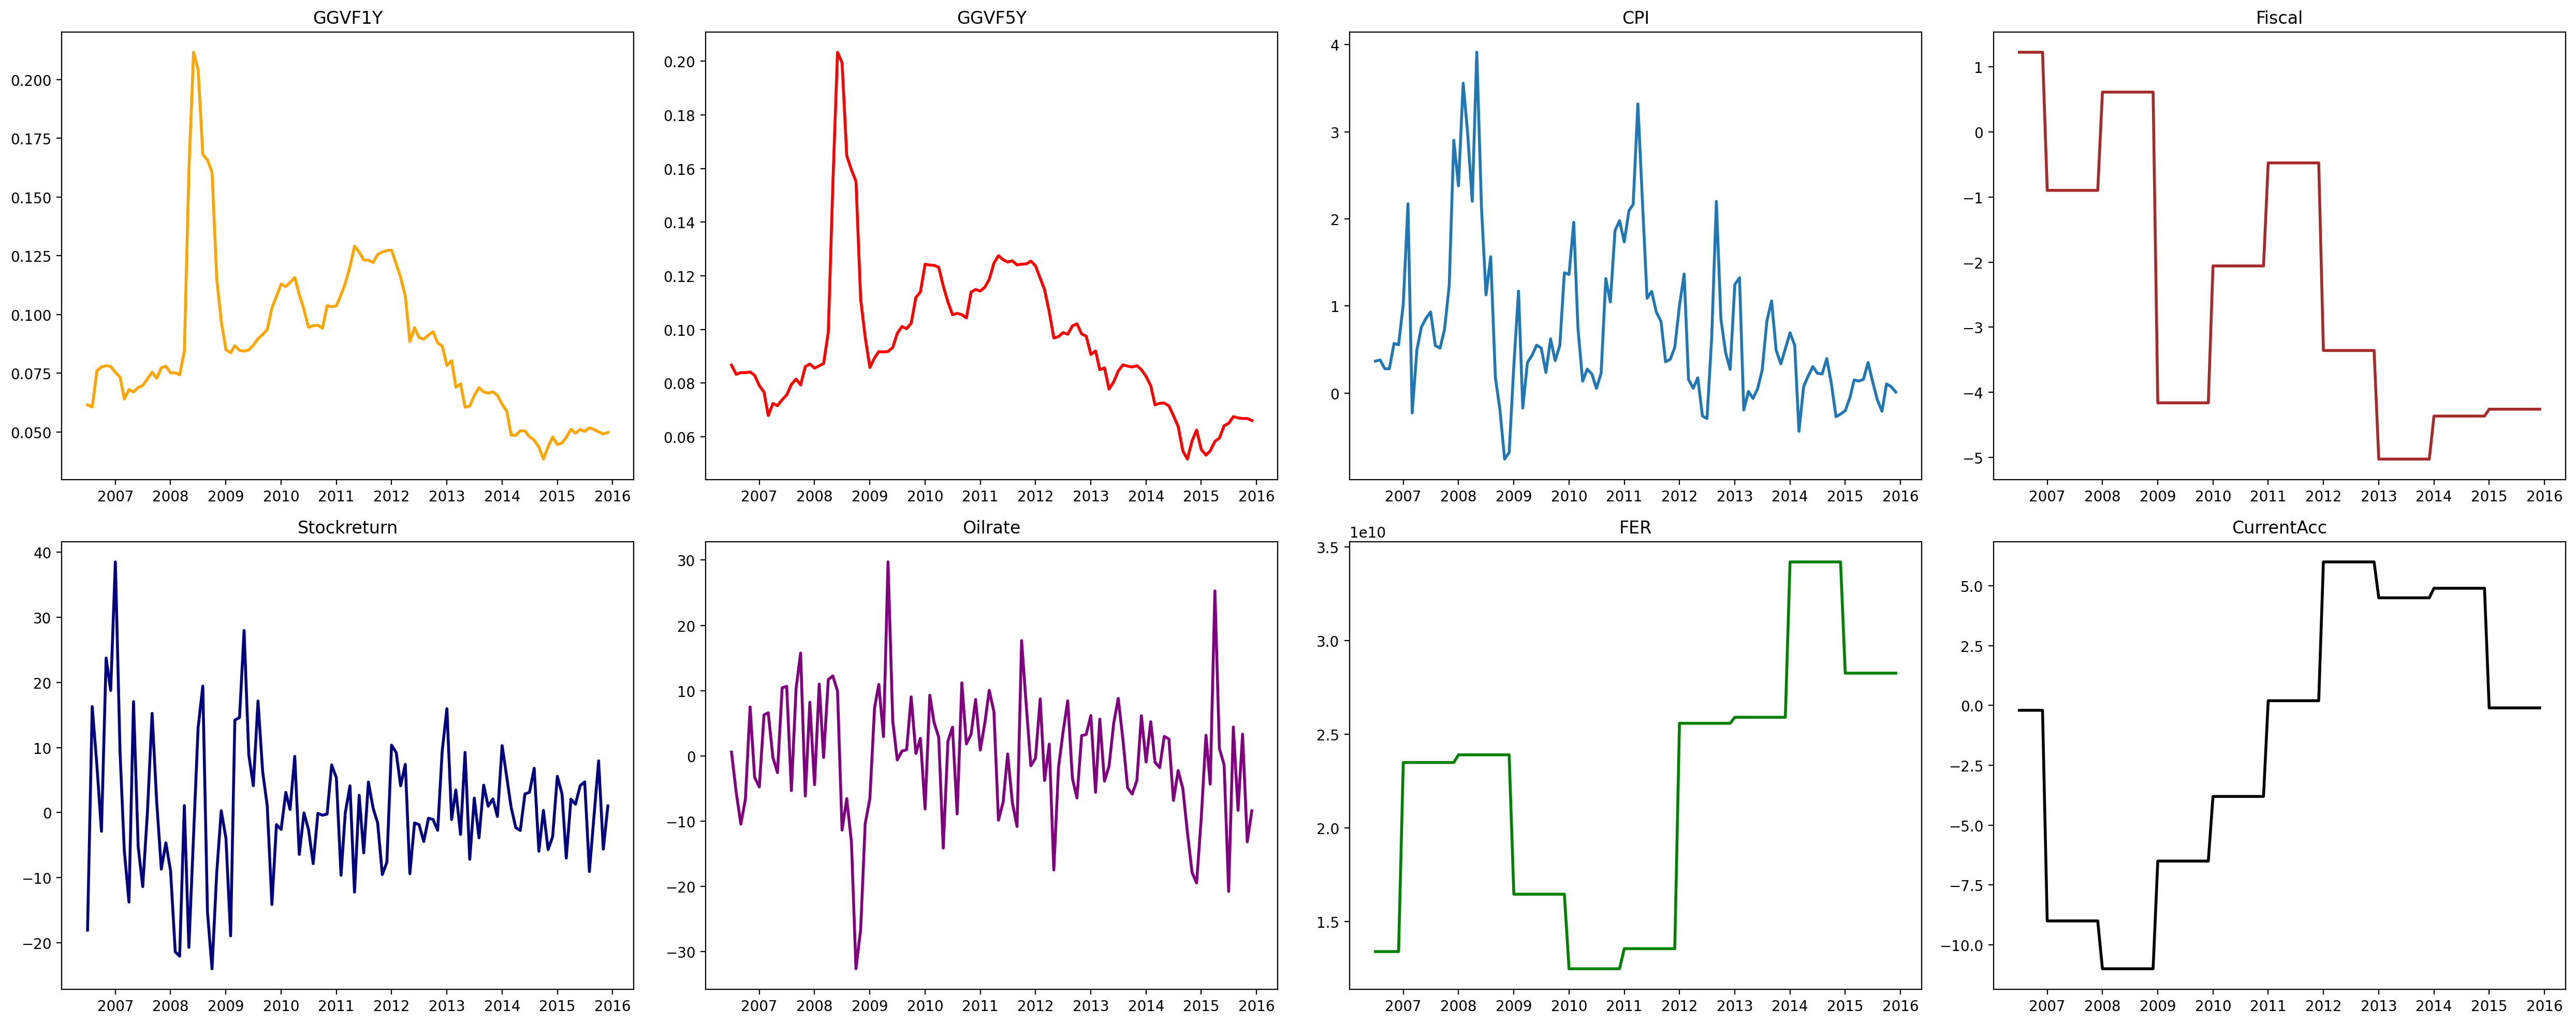

In [8]:
# using tuple unpacking for multiple Axes
fig, axs = plt.subplots(2,4, figsize=(25,10),dpi = 200)

axs[0,0].plot(x_train.GGVF1Y,linewidth =2, color = 'orange')
axs[0,0].set_title('GGVF1Y')

axs[0,1].plot(x_train.GGVF5Y,linewidth =2, color = 'red')
axs[0,1].set_title('GGVF5Y')

axs[0,2].plot(x_train.CPI,linewidth =2)
axs[0,2].set_title('CPI')

axs[0,3].plot(x_train.Fiscal,linewidth =2, color = 'brown')
axs[0,3].set_title('Fiscal')

axs[1,0].plot(x_train.Stockreturn,linewidth =2, color = 'navy')
axs[1,0].set_title('Stockreturn')

axs[1,1].plot(x_train.Oilrate,linewidth =2, color = 'purple')
axs[1,1].set_title('Oilrate')

axs[1,2].plot(x_train.FER,linewidth =2, color = 'green')
axs[1,2].set_title('FER')

axs[1,3].plot(x_train.CurrentAcc,linewidth =2, color = 'black')
axs[1,3].set_title('CurrentAcc')

# fig.suptitle('First differencing plot')
fig.tight_layout()

In [9]:
for i in x_train.columns:
    print(f'ADF test of {i}:\n{round(adf_test(df[i]),4)}\n')


ADF test of GGVF1Y:
Test Statistic             -1.5024
p-value                     0.5323
# of Lags Used              5.0000
# of Observations Used    156.0000
Critical Value (1%)        -3.4730
Critical Value (5%)        -2.8803
Critical Value (10%)       -2.5767
dtype: float64

ADF test of GGVF5Y:
Test Statistic             -1.1854
p-value                     0.6799
# of Lags Used              5.0000
# of Observations Used    156.0000
Critical Value (1%)        -3.4730
Critical Value (5%)        -2.8803
Critical Value (10%)       -2.5767
dtype: float64

ADF test of CPI:
Test Statistic             -4.2420
p-value                     0.0006
# of Lags Used              5.0000
# of Observations Used    156.0000
Critical Value (1%)        -3.4730
Critical Value (5%)        -2.8803
Critical Value (10%)       -2.5767
dtype: float64

ADF test of FER:
Test Statistic              0.2782
p-value                     0.9763
# of Lags Used              0.0000
# of Observations Used    161.0000
Cri

In [10]:
for i in x_train.columns:
    print(f'KPSS test of {i}:\n{round(kpss_test(df[i]),4)}\n')

KPSS test of GGVF1Y:
Test Statistic           1.2803
p-value                  0.0100
# of Lags                8.0000
Critical Value (10%)     0.3470
Critical Value (5%)      0.4630
Critical Value (2.5%)    0.5740
Critical Value (1%)      0.7390
dtype: float64

KPSS test of GGVF5Y:
Test Statistic           1.3291
p-value                  0.0100
# of Lags                8.0000
Critical Value (10%)     0.3470
Critical Value (5%)      0.4630
Critical Value (2.5%)    0.5740
Critical Value (1%)      0.7390
dtype: float64

KPSS test of CPI:
Test Statistic           0.6640
p-value                  0.0168
# of Lags                7.0000
Critical Value (10%)     0.3470
Critical Value (5%)      0.4630
Critical Value (2.5%)    0.5740
Critical Value (1%)      0.7390
dtype: float64

KPSS test of FER:
Test Statistic           1.5188
p-value                  0.0100
# of Lags                8.0000
Critical Value (10%)     0.3470
Critical Value (5%)      0.4630
Critical Value (2.5%)    0.5740
Critical V

# **Checking linear relation between current and past values**

*A quick test is to check if the data is random. Random data will not exhibit a structure in the lag plot.*

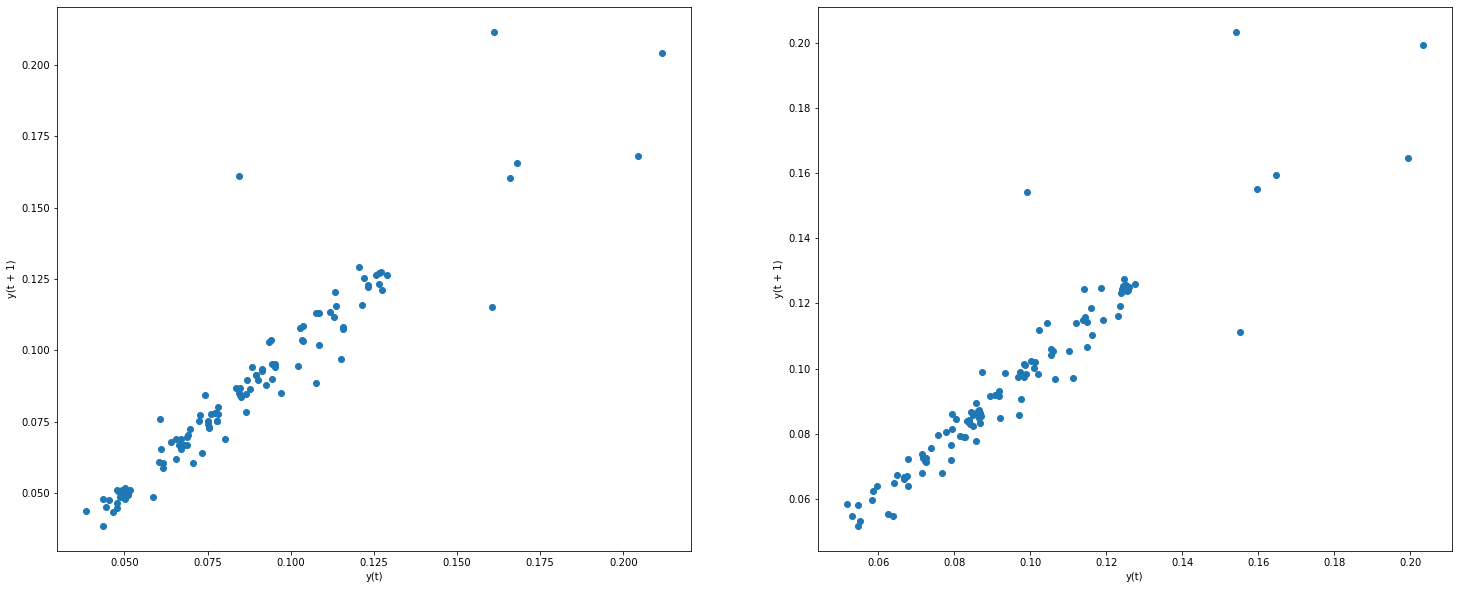

In [11]:
fig, ax = plt.subplots(1,2, figsize=(25,10)) 
ax[0] = pd.plotting.lag_plot(x_train.GGVF1Y,ax=ax[0])
ax[1] = pd.plotting.lag_plot(x_train.GGVF5Y,ax=ax[1])

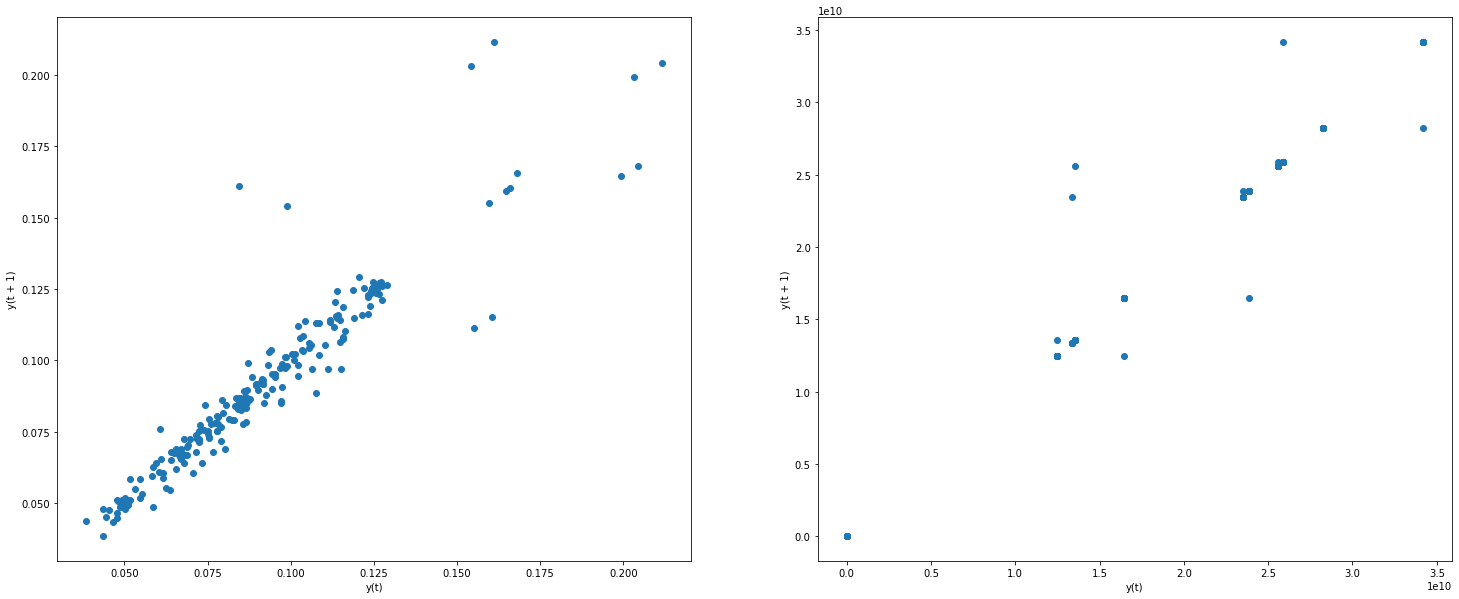

In [12]:
fig, ax = plt.subplots(1,2, figsize=(25,10)) 
ax[0] = pd.plotting.lag_plot(x_train[['GGVF1Y','GGVF5Y']],ax=ax[0])
ax[1] = pd.plotting.lag_plot(x_train,ax=ax[1])

*The time series plot clearly indicates some kind of relationships among the series. The linear shape of the lag plot suggests that an AR model is a better choice. We also don’t see any outlier in the data. Data here showing linear pattern, indicating the presence of positive auto-correlation.*

# **Testing Causation using Granger’s Causality Test**

**Source:**
*https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.grangercausalitytests.html*

In [13]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag= 6
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    dff = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in dff.columns:
        for r in dff.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            dff.loc[r, c] = min_p_value
    dff.columns = [var + '_x' for var in variables]
    dff.index = [var + '_y' for var in variables]
    return dff

grangers_causation_matrix(x_train, variables = x_train.columns)      

,GGVF1Y_x,GGVF5Y_x,CPI_x,FER_x,Oilrate_x,Stockreturn_x,Fiscal_x,CurrentAcc_x
GGVF1Y_y,1.0000,0.2637,0.0000,0.0318,0.0001,0.0759,0.0194,0.0667
GGVF5Y_y,0.0652,1.0000,0.0000,0.0470,0.0000,0.0699,0.0595,0.0744
CPI_y,0.4956,0.5463,1.0000,0.0407,0.0685,0.0073,0.0003,0.1158
FER_y,0.2742,0.2384,0.9220,1.0000,0.0571,0.2509,0.9609,0.0575
Oilrate_y,0.0886,0.1302,0.2710,0.1008,1.0000,0.2477,0.6627,0.4412
Stockreturn_y,0.0002,0.0000,0.0278,0.1686,0.0060,1.0000,0.0062,0.0235
Fiscal_y,0.0000,0.0000,0.0001,0.3159,0.0065,0.0613,1.0000,0.1755
CurrentAcc_y,0.0699,0.0815,0.8128,0.6028,0.5221,0.0879,0.3266,1.0000


# **Cointegration Test**

**Source:** 

*https://www.statsmodels.org/dev/generated/statsmodels.tsavector_ar.vecm.coint_johansen.html*

*https://www.statsmodels.org/dev/generated/statsmodels.tsa.vector_ar.vecm.JohansenTestResult.html*

In [14]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(dff, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(dff,-1,5)
    d = {'0.9':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)
    
    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Significant  \n', '--'*20)
    for col, trace, cvt in zip(dff.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(x_train)

Name   ::  Test Stat > C(95%)    =>   Significant  
 ----------------------------------------
GGVF1Y ::  246.39    > 143.6691  =>   True
GGVF5Y ::  155.57    > 111.7797  =>   True
CPI    ::  107.27    > 83.9383   =>   True
FER    ::  65.72     > 60.0627   =>   True
Oilrate ::  34.2      > 40.1749   =>   False
Stockreturn ::  19.68     > 24.2761   =>   False
Fiscal ::  6.65      > 12.3212   =>   False
CurrentAcc ::  0.08      > 4.1296    =>   False


# **Checking stationary**

*The VAR class assumes that the passed time series are stationary. Non-stationary or trending data can often be transformed to be stationary by first-differencing or some other method. For direct analysis of non-stationary time series, a standard stable VAR(p) model is not appropriate.*

*If the series is not stationary, a spurious regression occurs. For example, 2 data series that are not related to each other but have an upward or downward trend => fake regression*

In [15]:
X_train_log_diff  = x_train.diff().dropna()
X_train_log_diff.describe()

,GGVF1Y,GGVF5Y,CPI,FER,Oilrate,Stockreturn,Fiscal,CurrentAcc
count,113.000000,113.000000,113.000000,1.130000e+02,113.000000,113.000000,113.000000,113.000000
mean,-0.000104,-0.000183,-0.003142,1.315592e+08,-0.079747,0.168934,-0.048541,0.000885
std,0.011455,0.009748,0.669859,1.940043e+09,11.327422,12.190540,0.653278,1.288791
min,-0.045250,-0.043950,-2.400000,-7.443146e+09,-24.315513,-34.723763,-4.775480,-8.800000
25%,-0.002580,-0.002500,-0.244000,0.000000e+00,-7.493022,-6.839015,0.000000,0.000000
50%,-0.000170,-0.000050,0.031000,0.000000e+00,0.194761,-0.470810,0.000000,0.000000
75%,0.002080,0.002000,0.230000,0.000000e+00,6.017478,8.109668,0.000000,0.000000
max,0.076870,0.055200,1.711000,1.203416e+10,29.613945,34.352891,2.104080,5.800000


In [16]:
X_train_log_diff

,GGVF1Y,GGVF5Y,CPI,FER,Oilrate,Stockreturn,Fiscal,CurrentAcc
Time,,,,,,,,
2006-08-01,-0.00087,-0.00345,0.013,0.0,-6.145006,34.352891,0.0,0.0
2006-09-01,0.01537,0.00068,-0.100,0.0,-4.895887,-9.042719,0.0,0.0
2006-10-01,0.00167,-0.00005,-0.001,0.0,3.816299,-10.121503,0.0,0.0
2006-11-01,0.00050,0.00029,0.292,0.0,14.133993,26.637594,0.0,0.0
2006-12-01,-0.00034,-0.00125,-0.017,0.0,-10.784903,-5.000110,0.0,0.0
...,...,...,...,...,...,...,...,...
2015-08-01,0.00150,0.00250,-0.207,0.0,25.181035,-13.789799,0.0,0.0
2015-09-01,-0.00070,-0.00047,-0.132,0.0,-12.767920,8.693140,0.0,0.0
2015-10-01,-0.00102,-0.00023,0.314,0.0,11.680339,8.323638,0.0,0.0


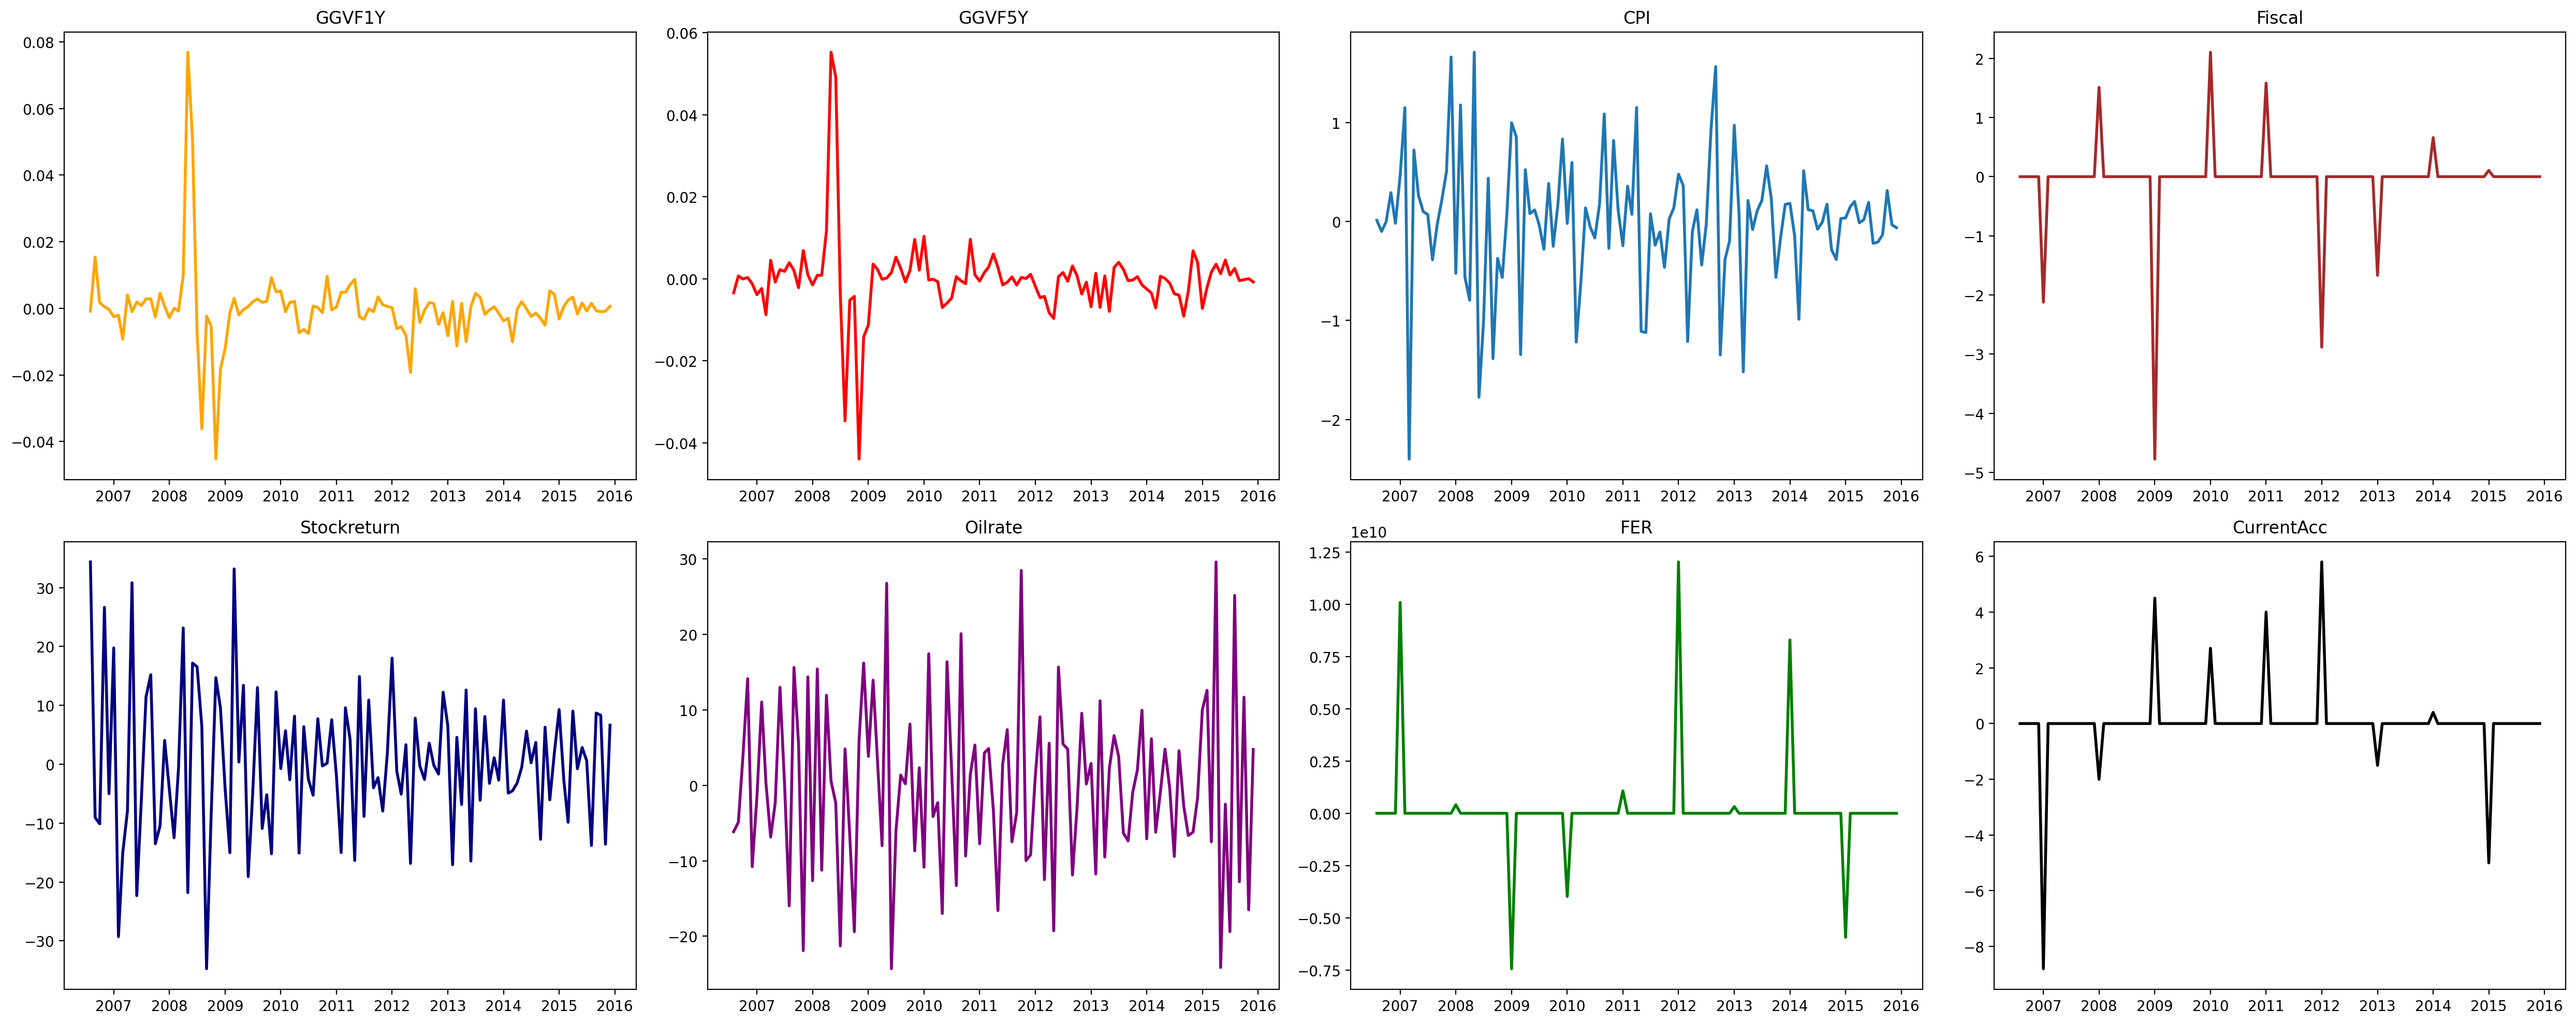

In [17]:
# using tuple unpacking for multiple Axes
fig, axs = plt.subplots(2,4, figsize=(25,10),dpi = 200)

axs[0,0].plot(X_train_log_diff.GGVF1Y,linewidth =2, color = 'orange')
axs[0,0].set_title('GGVF1Y')

axs[0,1].plot(X_train_log_diff.GGVF5Y,linewidth =2, color = 'red')
axs[0,1].set_title('GGVF5Y')

axs[0,2].plot(X_train_log_diff.CPI,linewidth =2)
axs[0,2].set_title('CPI')

axs[0,3].plot(X_train_log_diff.Fiscal,linewidth =2, color = 'brown')
axs[0,3].set_title('Fiscal')

axs[1,0].plot(X_train_log_diff.Stockreturn,linewidth =2, color = 'navy')
axs[1,0].set_title('Stockreturn')

axs[1,1].plot(X_train_log_diff.Oilrate,linewidth =2, color = 'purple')
axs[1,1].set_title('Oilrate')

axs[1,2].plot(X_train_log_diff.FER,linewidth =2, color = 'green')
axs[1,2].set_title('FER')

axs[1,3].plot(X_train_log_diff.CurrentAcc,linewidth =2, color = 'black')
axs[1,3].set_title('CurrentAcc')

# fig.suptitle('First differencing plot')
fig.tight_layout()

In [18]:
for i in X_train_log_diff.columns:
    print(f'ADF test of {i}:\n{round(adf_test(X_train_log_diff[i]),4)}\n')

ADF test of GGVF1Y:
Test Statistic             -7.3659
p-value                     0.0000
# of Lags Used              1.0000
# of Observations Used    111.0000
Critical Value (1%)        -3.4907
Critical Value (5%)        -2.8880
Critical Value (10%)       -2.5809
dtype: float64

ADF test of GGVF5Y:
Test Statistic             -5.6186
p-value                     0.0000
# of Lags Used              4.0000
# of Observations Used    108.0000
Critical Value (1%)        -3.4924
Critical Value (5%)        -2.8887
Critical Value (10%)       -2.5813
dtype: float64

ADF test of CPI:
Test Statistic             -5.1865
p-value                     0.0000
# of Lags Used              5.0000
# of Observations Used    107.0000
Critical Value (1%)        -3.4930
Critical Value (5%)        -2.8890
Critical Value (10%)       -2.5814
dtype: float64

ADF test of FER:
Test Statistic            -10.5373
p-value                     0.0000
# of Lags Used              0.0000
# of Observations Used    112.0000
Cri

*(1) p-value < 0,05 => time series are stationary*

In [19]:
for i in X_train_log_diff.columns:
    print(f'KPSS test of {i}:\n{round(kpss_test(X_train_log_diff[i]),4)}\n')

KPSS test of GGVF1Y:
Test Statistic           0.085
p-value                  0.100
# of Lags                3.000
Critical Value (10%)     0.347
Critical Value (5%)      0.463
Critical Value (2.5%)    0.574
Critical Value (1%)      0.739
dtype: float64

KPSS test of GGVF5Y:
Test Statistic           0.0601
p-value                  0.1000
# of Lags                3.0000
Critical Value (10%)     0.3470
Critical Value (5%)      0.4630
Critical Value (2.5%)    0.5740
Critical Value (1%)      0.7390
dtype: float64

KPSS test of CPI:
Test Statistic            0.0628
p-value                   0.1000
# of Lags                10.0000
Critical Value (10%)      0.3470
Critical Value (5%)       0.4630
Critical Value (2.5%)     0.5740
Critical Value (1%)       0.7390
dtype: float64

KPSS test of FER:
Test Statistic           0.0811
p-value                  0.1000
# of Lags                0.0000
Critical Value (10%)     0.3470
Critical Value (5%)      0.4630
Critical Value (2.5%)    0.5740
Critical V

*(2) p-value > 0,05 => time series are stationary*

**(1) và (2) => time series are stationary**

# **Lag order selection**
*Choice of lag order can be a difficult problem. Standard analysis employs likelihood test or information criteria-based order selection. We have implemented the latter, accessible through the VAR class:*

In [20]:
model = VAR(endog=X_train_log_diff)

res = model.select_order(maxlags=6)
res.summary()

,AIC,BIC,FPE,HQIC
0,29.22,29.42*,4.904e+12,29.30*
1,29.20,30.99,4.799e+12,29.93
2,28.93,32.32,3.734e+12,30.30
3,29.05,34.05,4.455e+12,31.08
4,28.78*,35.37,3.712e+12*,31.45
5,29.24,37.43,6.940e+12,32.56
6,29.61,39.40,1.303e+13,33.58


# **Model fitting**
*To actually do the estimation, call the fit method with the optimal lag order. Or you can have the model select a lag order based on a standard information criterion.*

In [21]:
# When calling the fit function, one can pass a maximum number of lags and the order criterion to use for order selection
model_fit = model.fit(maxlags=4,ic='aic')
model_fit.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 30, May, 2022
Time:                     09:40:05
--------------------------------------------------------------------
No. of Equations:         8.00000    BIC:                    36.1191
Nobs:                     109.000    HQIC:                   32.2441
Log likelihood:          -2586.55    FPE:                8.38414e+12
AIC:                      29.6006    Det(Omega_mle):     1.01056e+12
--------------------------------------------------------------------
Results for equation GGVF1Y
                    coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------
const                  0.000113         0.000944            0.119           0.905
L1.GGVF1Y              0.069135         0.375716            0.184           0.854
L1.GGVF5Y              0.648873         0.462626       

# **Granger causality**
*One is often interested in whether a variable or group of variables is “causal” for another variable, for some definition of “causal”. In the context of VAR models, one can say that a set of variables are Granger-causal within one of the VAR equations. The **VARResults** object has the test_causality method for performing either a Wald **(X^2)** test or an F-test.*

In [22]:
granger_test =model_fit.test_causality('GGVF1Y', df.columns[1:], kind='f')
print('GGVF1Y:\n',granger_test.summary(),'\n')

granger_test =model_fit.test_causality('GGVF5Y', df[['GGVF1Y', 'CPI', 'Oilrate', 'Stockreturn', 'Fiscal', 'CurrentAcc']], kind='f')
print('GGVF5Y:\n',granger_test.summary())

GGVF1Y:
 Granger causality F-test. H_0: ['GGVF5Y', 'CPI', 'FER', 'Oilrate', 'Stockreturn', 'Fiscal', 'CurrentAcc'] do not Granger-cause GGVF1Y. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value     df   
-----------------------------------------------
         1.449          1.495   0.065 (28, 608)
----------------------------------------------- 

GGVF5Y:
 Granger causality F-test. H_0: ['GGVF1Y', 'CPI', 'Oilrate', 'Stockreturn', 'Fiscal', 'CurrentAcc'] do not Granger-cause GGVF5Y. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value     df   
-----------------------------------------------
         1.713          1.535   0.019 (24, 608)
-----------------------------------------------


# **Normality**
*The white noise component is assumed to be normally distributed. While this assumption is not required for parameter estimates to be consistent or asymptotically normal, results are generally more reliable in finite samples when residuals are Gaussian white noise. To test whether this assumption is consistent with a data set, **VARResults** offers the test_normality method.*

In [23]:
test_normal = model_fit.test_normality()
print(test_normal.summary())

normality (skew and kurtosis) test. H_0: data generated by normally-distributed process. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
         2756.          26.30   0.000 16
----------------------------------------


# **Check for Serial Correlation of Residuals**
*If there is any correlation left in the residuals, then, there is some pattern in the time series that is still left to be explained by the model. In that case, the typical course of action is to either increase the order of the model or induce more predictors into the system or look for a different algorithm to model the time series.*

In [24]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fit.resid)

*The value of this statistic can vary between 0 and 4. The closer it is to the value 2, then there is no significant serial correlation. The closer to 0, there is a positive serial correlation, and the closer it is to 4 implies negative serial correlation.*

In [25]:
for col, val in zip(df.columns, out):
    print(adjust(col), ':', round(val, 2))

GGVF1Y : 2.1
GGVF5Y : 2.15
CPI    : 1.86
FER    : 2.02
Oilrate : 2.02
Stockreturn : 1.93
Fiscal : 2.07
CurrentAcc : 2.17


*The serial correlation seems quite alright*

# **Forcasting**
*The linear predictor is the optimal h-step ahead forecast in terms of mean-squared error*



In [26]:
# Get the lag order
lag_order = model_fit.k_ar

# Input data for forecasting
input_data = X_train_log_diff.values[-lag_order:]

# Forecasting
pred = model_fit.forecast(y=input_data, steps=obs)
pred_df = (pd.DataFrame(pred, index=x_test.index, columns=x_test.columns + '_pred'))
pred_df.head()

,GGVF1Y_pred,GGVF5Y_pred,CPI_pred,FER_pred,Oilrate_pred,Stockreturn_pred,Fiscal_pred,CurrentAcc_pred
Time,,,,,,,,
2016-01-01,-0.002386,-0.002230,-0.213541,-4.477383e+08,1.751062,-2.512955,0.229700,-0.122401
2016-02-01,0.000999,0.000453,-0.078255,-3.144491e+07,1.253223,0.085524,0.090057,0.090775
2016-03-01,-0.000624,-0.000462,0.340293,-1.156796e+08,-1.201445,0.908294,-0.423066,0.054113
2016-04-01,0.000274,0.000382,-0.064579,5.128122e+08,-0.287929,0.797131,-0.010465,-0.086600
2016-05-01,0.000720,0.000378,-0.056718,2.168325e+08,1.076348,-0.011774,-0.109567,0.085006


<Figure size 1800x720 with 0 Axes>

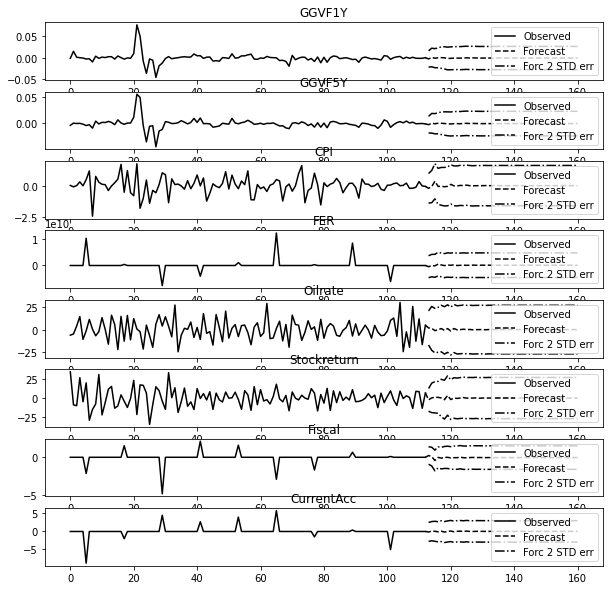

In [27]:
plt.figure(figsize= (25,10))
model_fit.plot_forecast(obs)

plt.show()

In [28]:
# Inverting transformation
def invert_transformation(x_train, pred_df):
  forecast = pred_df.copy()
  columns = x_train.columns
  for col in columns:
    forecast[str(col)+'_pred'] = x_train[col].iloc[-1] + forecast[str(col) +'_pred'].cumsum()
  return forecast

output = invert_transformation(x_train, pred_df)

output_original = np.exp(output)

**Visualization**

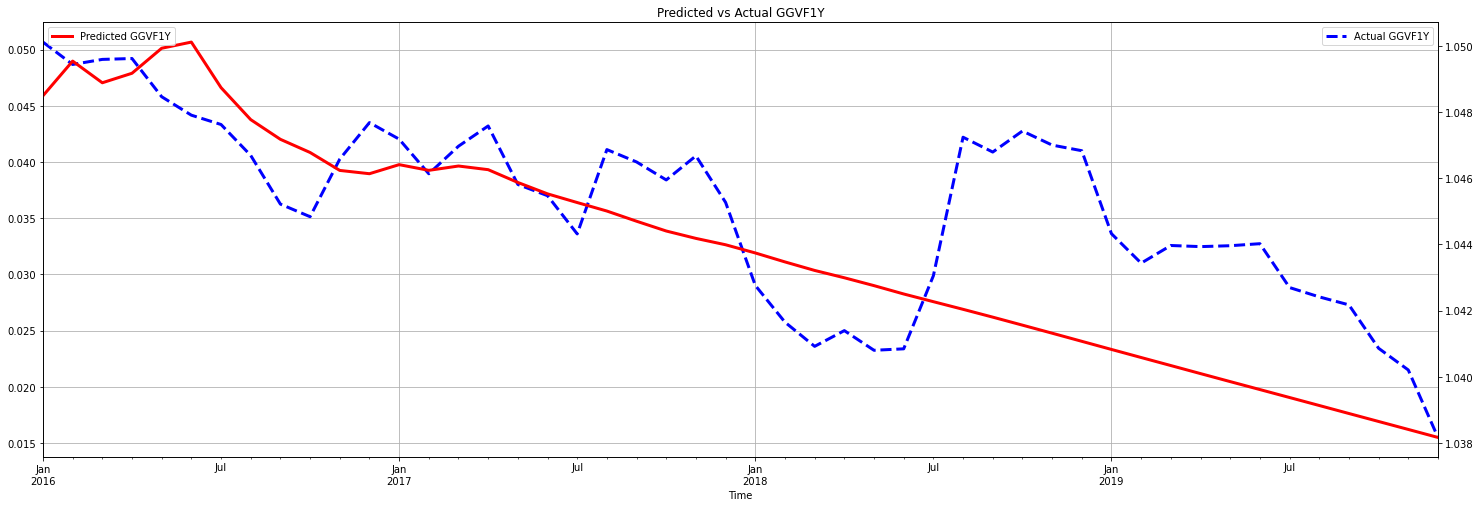

In [29]:
plt.figure(figsize= (25,8))
plt.xlabel('Date')
ax1=x_test.GGVF1Y.plot(color='blue', grid = True, label='Actual GGVF1Y',linewidth= 3,linestyle='dashed')
ax2=output_original.GGVF1Y_pred.plot(color='red', grid=True, secondary_y=True, label='Predicted GGVF1Y',linewidth= 3)
ax1.legend(loc=1)
ax2.legend(loc=2)
plt.title('Predicted vs Actual GGVF1Y')
plt.show()

In [30]:
#Calculate forecast bias
forecast_errors = [x_test['GGVF1Y'][i]- output_original['GGVF1Y_pred'][i] for i in range(len(x_test['GGVF1Y']))]
bias = sum(forecast_errors) * 1.0/len(x_test['GGVF1Y'])
print('Bias: %f' % bias)

mape = (mean_absolute_percentage_error(x_test['GGVF1Y'],output_original['GGVF1Y_pred']))
print(f'MAPE: {round(mape,2)}%')

#Calculate mean absolute error
mae = mean_absolute_error(x_test['GGVF1Y'],output_original['GGVF1Y_pred'])
print('MAE: %f' % mae)

#Calculate mean squared error and root mean squared error
mse = mean_squared_error(x_test['GGVF1Y'],output_original['GGVF1Y_pred'])
print('MSE: %f' % mse)
rmse = np.sqrt(mse)
print('RMSE: %f' % rmse)

Bias: -1.007936
MAPE: 29.97%
MAE: 1.007936
MSE: 1.015973
RMSE: 1.007955


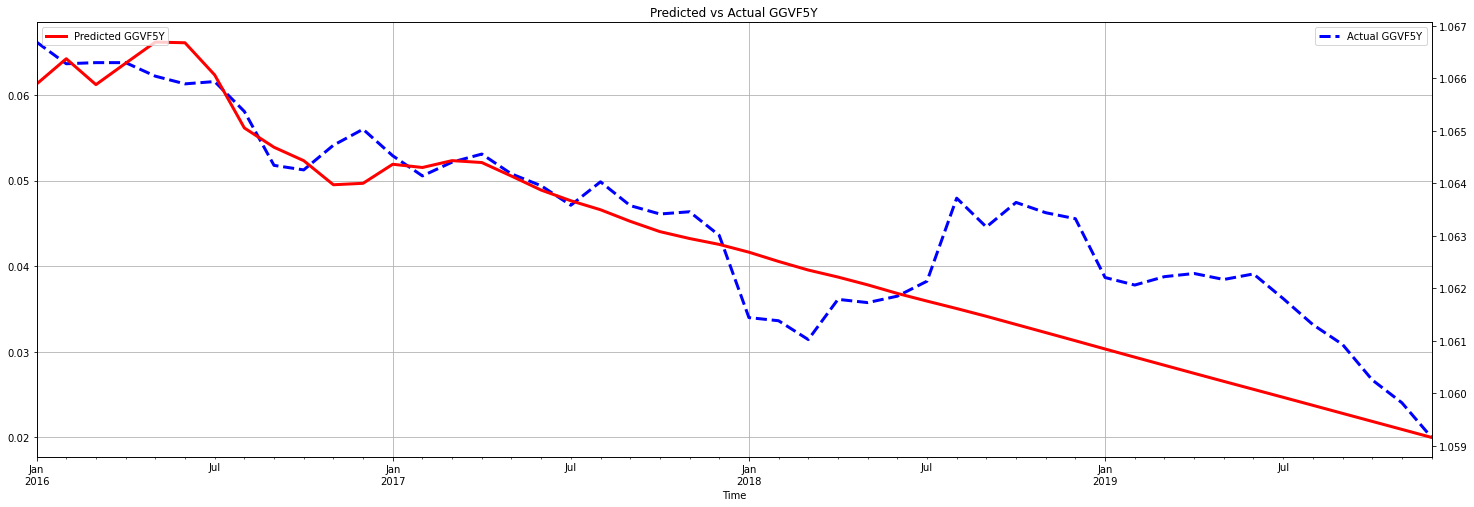

In [31]:
plt.figure(figsize= (25,8))
plt.xlabel('Date')
ax1=x_test.GGVF5Y.plot(color='blue', grid = True, label='Actual GGVF5Y',linewidth= 3,linestyle='dashed')
ax2=output_original.GGVF5Y_pred.plot(color='red', grid=True, secondary_y=True, label='Predicted GGVF5Y',linewidth= 3)
ax1.legend(loc=1)
ax2.legend(loc=2)
plt.title('Predicted vs Actual GGVF5Y')
plt.show()

In [32]:
#Calculate forecast bias
forecast_errors = [x_test['GGVF5Y'][i]- output_original['GGVF5Y_pred'][i] for i in range(len(x_test['GGVF5Y']))]
bias = sum(forecast_errors) * 1.0/len(x_test['GGVF5Y'])
print('Bias: %f' % bias)

mape = (mean_absolute_percentage_error(x_test['GGVF5Y'],output_original['GGVF5Y_pred']))
print(f'MAPE: {round(mape,2)}%')

#Calculate mean absolute error
mae = mean_absolute_error(x_test['GGVF5Y'],output_original['GGVF5Y_pred'])
print('MAE: %f' % mae)

#Calculate mean squared error and root mean squared error
mse = mean_squared_error(x_test['GGVF5Y'],output_original['GGVF5Y_pred'])
print('MSE: %f' % mse)
rmse = np.sqrt(mse)
print('RMSE: %f' % rmse)

Bias: -1.017285
MAPE: 24.03%
MAE: 1.017285
MSE: 1.034953
RMSE: 1.017326


# **Referrence**

*[1] Campbell, J. Y., & Shiller, R. J. (1991). Yield spreads and interest rate movements: A bird's eye view. The Review of Economic Studies, 58(3), 495-514.*

*[2] Cieslak, A., & Povala, P. (2015). Expected returns in Treasury bonds. The Review of Financial Studies, 28(10), 2859-2901.*

*[3] Developing Vector AutoRegressive Model in Python! - Analytics Vidhya. (2021). Retrieved 20 May 2022, from https://www.analyticsvidhya.com/blog/2021/08/vector-autoregressive-model-in-python*

*[4] Ghysels, E., Horan, C., & Moench, E. (2018). Forecasting through the rearview mirror: Data revisions and bond return predictability. The Review of Financial Studies, 31(2), 678-714.*

*[5] Kameda, K. (2014). Budget deficits, government debt, and long-term interest rates in Japan. Journal of the Japanese and International Economies, 32, 105-124.*

*[6] Ludvigson, S. C., & Ng, S. (2009). Macro factors in bond risk premia. The Review of Financial Studies, 22(12), 5027-5067.*

*[7] Selva Prabhakaran. (2022). Retrieved 20 May 2022, from https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python*

*[8] Suimon, Y., Sakaji, H., Shimada, T., Izumi, K., & Matsushima, H. (2019). Japanese long-term interest rate forecast considering the connection between the Japanese and US yield curve. Paper presented at the 2019 IEEE Conference on Computational Intelligence for Financial Engineering & Economics (CIFEr).*

*[9] TRINH, Q. T., NGUYEN, A. P., NGUYEN, H. A., & NGO, P. T. (2020). Determinants of Vietnam government bond yield volatility: A GARCH approach. The Journal of Asian Finance, Economics, and Business, 7(7), 15-25.* 

*[10] Time-series Analysis with VAR & VECM: Statistical approach with complete Python code. (2021). Retrieved 20 May 2022, from https://towardsdatascience.com/vector-autoregressions-vector-error-correction-multivariate-model-a69daf6ab618*

*[11] Vector Autoregressions tsa.vector_ar — statsmodels. (2022). Retrieved 20 May 2022, from https://www.statsmodels.org/dev/vector_ar.html#granger-causality*